In [1]:
import pandas as pd
import numpy as np
import retrieval_311
from sklearn.preprocessing import StandardScaler
from pandas.tseries.holiday import USFederalHolidayCalendar as calendar
from sklearn.metrics import mean_absolute_error

from sklearn.model_selection import TimeSeriesSplit


In [2]:
df = retrieval_311.process_data()

Data available locally
Processing data


In [3]:

df = retrieval_311.bulk_download_311()

Data available locally


In [31]:
df = df[df.index < "2023-04-05"].sort_index().tail(30)

In [5]:
df['datetime'] = pd.to_datetime(df['Opened'], format="%m/%d/%Y %I:%M:%S %p")

In [6]:
df = df.set_index('datetime')

In [7]:
df_hourly = df.resample('1H').count().iloc[:, 0:1]
df_hourly.columns = ['calls']

In [8]:
df_hourly['month'] = df_hourly.index.month
df_hourly['dayofweek'] = df_hourly.index.dayofweek
df_hourly['dayofmonth'] = df_hourly.index.day
df_hourly['hourofday'] = df_hourly.index.hour

In [32]:
df_hourly.reset_index()

,datetime,calls,month,dayofweek,dayofmonth,hourofday,holiday
0,2008-07-01 00:00:00,2,7,1,1,0,0
1,2008-07-01 01:00:00,0,7,1,1,1,0
2,2008-07-01 02:00:00,0,7,1,1,2,0
3,2008-07-01 03:00:00,1,7,1,1,3,0
4,2008-07-01 04:00:00,0,7,1,1,4,0
...,...,...,...,...,...,...,...
129477,2023-04-08 21:00:00,13,4,5,8,21,0
129478,2023-04-08 22:00:00,15,4,5,8,22,0
129479,2023-04-08 23:00:00,6,4,5,8,23,0
129480,2023-04-09 00:00:00,13,4,6,9,0,0


In [10]:
holidays = (
 calendar()
 .holidays(start=df_hourly.index.min(),
 end=df_hourly.index.max())
)
df_hourly['holiday'] = (pd.Series(df_hourly.index.date).isin(holidays.date) * 1).values

In [11]:
df_hourly

,calls,month,dayofweek,dayofmonth,hourofday,holiday
datetime,,,,,,
2008-07-01 00:00:00,2,7,1,1,0,0
2008-07-01 01:00:00,0,7,1,1,1,0
2008-07-01 02:00:00,0,7,1,1,2,0
2008-07-01 03:00:00,1,7,1,1,3,0
2008-07-01 04:00:00,0,7,1,1,4,0
...,...,...,...,...,...,...
2023-04-08 21:00:00,13,4,5,8,21,0
2023-04-08 22:00:00,15,4,5,8,22,0
2023-04-08 23:00:00,6,4,5,8,23,0


In [19]:
n_splits = 12

# create TimeSeriesSplit object
tscv = TimeSeriesSplit(n_splits=n_splits)

In [20]:
# iterate over each split and fit the model
rmses = []
for train_index, test_index in tscv.split(df_hourly):
    # get the training and test data for this split
    train_data = df_hourly.iloc[train_index]
    test_data = df_hourly.iloc[test_index]
    # Baseline Model
    preds = (train_data
             .groupby([train_data['month'],
                       train_data['dayofweek'],
                       train_data['hourofday']])
             ['calls']
             .mean()).to_dict()
    test_preds = (
        test_data
        .apply(lambda x: preds.get((x.month,
                                    x.dayofweek,
                                    x.hourofday)),
                axis=1)
    )
    mae_test = mean_absolute_error(test_data['calls'], test_preds)
    rmse = np.mean((test_data['calls'] - test_preds)**2)**.5
    print(rmse)
    rmses.append(rmse)
print("Mean RMSE:", np.mean(rmses))


3.8518143121148882
4.249432637796426
4.38644092596095
5.5415296200364565
8.776183110955028
12.299819121021281
17.951253378038526
21.38698639083751
24.679284345004834
27.155085431573532
29.315187684307887
27.87422189079208
Mean RMSE: 15.622269904036616


<AxesSubplot: xlabel='datetime'>

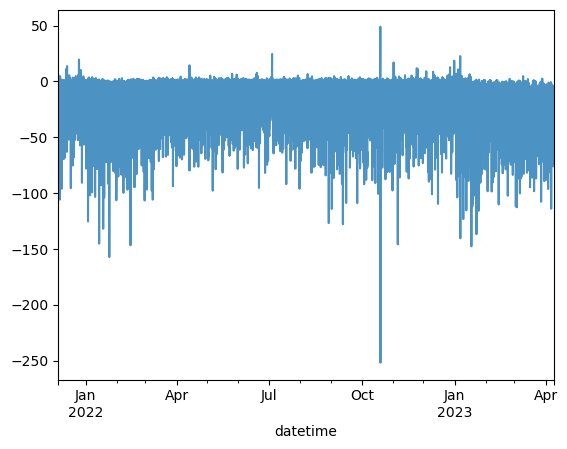

In [96]:
(test_preds - test_data['calls']).plot(alpha=.8)

In [52]:
# Split the data into training and testing sets
train_size = int(len(df_hourly) * 0.8)
train, test = df_hourly.iloc[:train_size], df_hourly.iloc[train_size:]

# Normalize the data
scaler = StandardScaler()
train_scaled = scaler.fit_transform(train)
test_scaled = scaler.transform(test)

# Format the data for a LSTM model
def create_dataset(X, y, time_steps=1):
    Xs, ys = [], []
    for i in range(len(X) - time_steps):
        Xs.append(X[i:(i+time_steps)])
        ys.append(y[i+time_steps])
    return np.array(Xs), np.array(ys)

time_steps = 24
X_train, y_train = create_dataset(train_scaled, train_scaled, time_steps)
X_test, y_test = create_dataset(test_scaled, test_scaled, time_steps)

# Train the LSTM model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

model = Sequential()
model.add(LSTM(128, input_shape=(X_train.shape[1], X_train.shape[2])))
model.add(Dense(1))
model.compile(loss='mae', optimizer='adam')

history = model.fit(X_train, y_train, epochs=5, batch_size=64, validation_split=0.1, shuffle=False)

Epoch 1/5
1457/1457 [==============================] - 35s 22ms/step - loss: 0.5912 - val_loss: 0.7603
Epoch 2/5
1457/1457 [==============================] - 32s 22ms/step - loss: 0.5810 - val_loss: 0.7521
Epoch 3/5
1457/1457 [==============================] - 33s 23ms/step - loss: 0.5788 - val_loss: 0.7517
Epoch 4/5
1457/1457 [==============================] - 33s 22ms/step - loss: 0.5784 - val_loss: 0.7497
Epoch 5/5
1457/1457 [==============================] - 32s 22ms/step - loss: 0.5779 - val_loss: 0.7489


In [55]:
train_pred = model.predict(X_train)

3237/3237 [==============================] - 43s 13ms/step


In [58]:
y_train

array([[-0.71398796, -0.49992278, -1.66129462],
       [-0.65756477, -0.49992278, -1.51683282],
       [-0.71398796, -0.49992278, -1.37237103],
       ...,
       [-0.37544883,  0.50036699,  1.5168649 ],
       [-0.5447184 ,  0.50036699,  1.6613267 ],
       [-0.71398796,  1.00051187, -1.66129462]])

In [57]:
mae = mean_absolute_error(y_train, train_pred)
print(f'Training MAE: {mae}')

ValueError: y_true and y_pred have different number of output (3!=1)